In [2]:
using DrWatson

In [3]:
@quickactivate :ReactiveMPPaperExperiments

  Activating environment at `~/.julia/dev/ReactiveMPPaperExperiments/Project.toml`


In [180]:
using Distributions
using Turing
using Random
using BenchmarkTools
using CairoMakie
using ProgressMeter

In [62]:
@model HGF(y, zt_min_mean, zt_min_std, xt_min_mean, xt_min_std, k, w, z_std, y_std) = begin
    # Priors
    zt_min ~ Normal(zt_min_mean, zt_min_std)
    xt_min ~ Normal(xt_min_mean, xt_min_std)

    zt ~ Normal(zt_min, z_std)
    xt ~ Normal(xt_min, sqrt(exp(k * zt + w)))

    y ~ Normal(xt, y_std)
end

HGF (generic function with 1 method)

In [184]:
setprogress!(false)

┌ Info: [Turing]: progress logging is disabled globally
└ @ Turing /Users/bvdmitri/.julia/packages/Turing/y0DW3/src/Turing.jl:22
┌ Info: [AdvancedVI]: global PROGRESS is set as false
└ @ AdvancedVI /Users/bvdmitri/.julia/packages/AdvancedVI/yCVq7/src/AdvancedVI.jl:15


false

In [293]:
function generate_data(n, k, w, z_std, y_std; seed)
    rng = MersenneTwister(seed)

    z_prev = 0.0
    x_prev = 0.0

    z = Vector{Float64}(undef, n)
    v = Vector{Float64}(undef, n)
    x = Vector{Float64}(undef, n)
    y = Vector{Float64}(undef, n)

    y_variance = 0.01
    z_variance = 1.0

    for i in 1:n
        z[i] = rand(rng, Normal(z_prev, z_std))
        v[i] = exp(k * z[i] + w)
        x[i] = rand(rng, Normal(x_prev, sqrt(v[i])))
        y[i] = rand(rng, Normal(x[i], y_std))

        z_prev = z[i]
        x_prev = x[i]
    end 
    
    return z, x, y
end

generate_data (generic function with 1 method)

In [294]:
n = 300
k = 1.0
w = 0.0
z_std = 0.5
y_std = 1.0

1.0

In [295]:
z, x, y = generate_data(n, k, w, z_std, y_std; seed = 123);

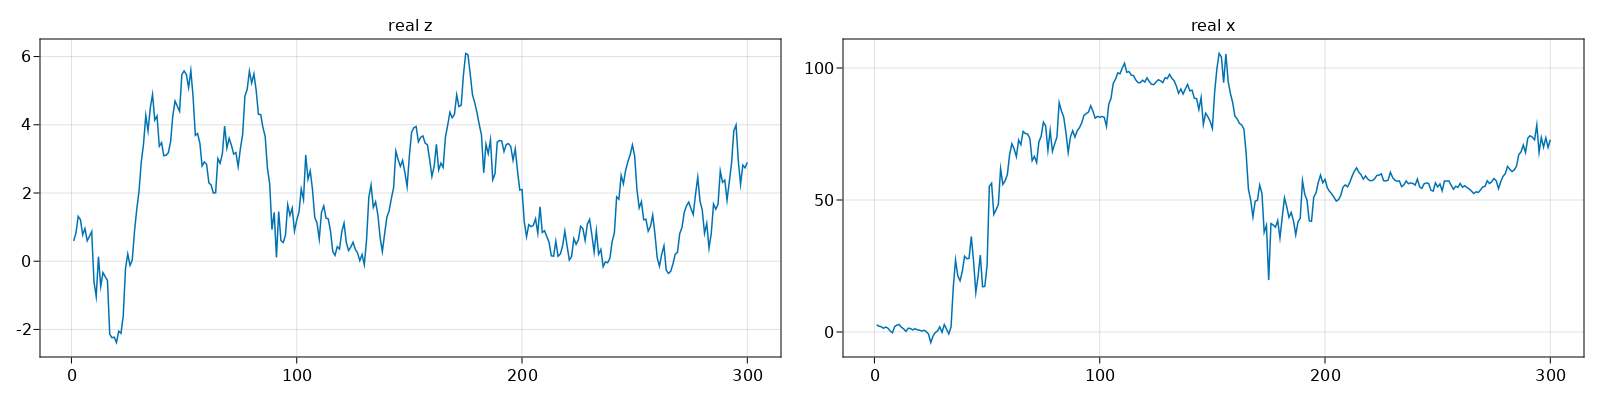

In [296]:
let 
    f = Figure(resolution = (1600, 400))
    
    ax1 = Axis(f[1, 1], title = "real z")
    ax2 = Axis(f[1, 2], title = "real x")
    
    lines!(ax1, 1:n, z)
    lines!(ax2, 1:n, x)
    # scatter!(ax2, 1:n, y)
    
    f
end

In [255]:
method = HMC(0.1, 10)
chain = sample(HGF(y[1], 0.0, 10.0, 0.0, 10.0, k, w, z_std, y_std), method, 100);

In [256]:
function extract_params_for_next_step(chain)
    sumstats = Turing.summarize(chain, Turing.mean, Turing.std)
    
    xt_index = findnext(e -> e === :xt, sumstats.nt.parameters, 1)
    zt_index = findnext(e -> e === :zt, sumstats.nt.parameters, 1)
    
    return (
        xt_min_mean = sumstats.nt.mean[xt_index],
        xt_min_std  = sumstats.nt.std[xt_index],
        zt_min_mean = sumstats.nt.mean[zt_index],
        zt_min_std  = sumstats.nt.std[zt_index],
    )
end


extract_params_for_next_step (generic function with 1 method)

In [257]:
function inference(y, k, w, z_std, y_std; nsamples = 100, method = HMC(0.1, 10), seed = 42)
    rng = MersenneTwister(seed)
    
    zt_min_mean = 0.0
    zt_min_std  = sqrt(100.0)
    xt_min_mean = 0.0
    xt_min_std  = sqrt(100.0)
    
    results = []
    
    @showprogress for i in 1:length(y)
        
        chain = sample(rng, HGF(y[i], zt_min_mean, zt_min_std, xt_min_mean, xt_min_std, k, w, z_std, y_std), method, nsamples);
        stats = extract_params_for_next_step(chain)
        
        zt_min_mean = stats[:zt_min_mean]
        xt_min_mean = stats[:xt_min_mean]
        zt_min_std = stats[:zt_min_std]
        xt_min_std = stats[:xt_min_std]
        
        push!(results, stats)
    end
    
    return results
end

inference (generic function with 1 method)

In [286]:
results = inference(y, k, w, z_std, y_std; nsamples = 10000, method = HMC(0.01, 75));

Progress: 100%|█████████████████████████████████████████| Time: 0:12:12


In [287]:
using CairoMakie

In [288]:
function extract_stats(results, sym::Symbol)
    return map(i -> i[sym], results)
end

extract_stats (generic function with 1 method)

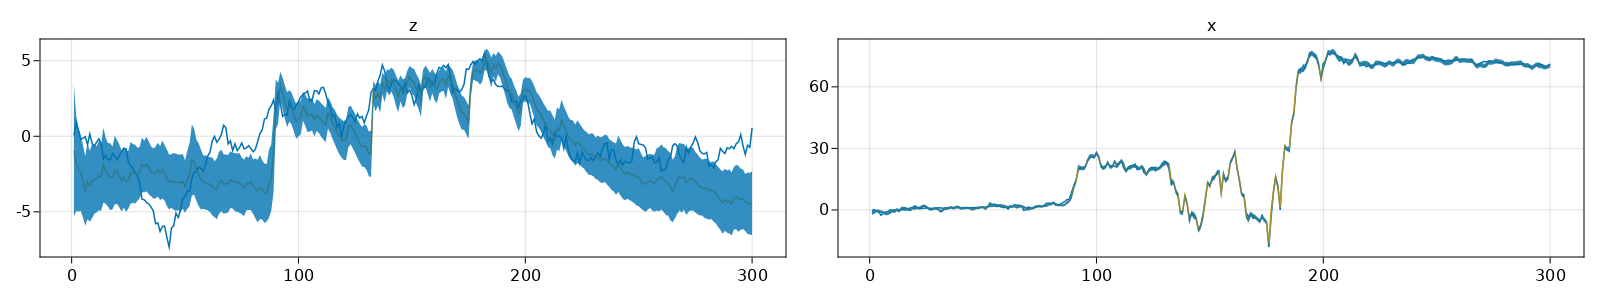

In [289]:
let
    f = Figure(resolution = (1600, 300))
    
    ax1 = Axis(f[1, 1], title = "z")
    ax2 = Axis(f[1, 2], title = "x")
    
    z_mean = extract_stats(results, :zt_min_mean)
    z_std  = extract_stats(results, :zt_min_std)
    
    lines!(ax1, 1:n, z)
    lines!(ax1, 1:n, z_mean)
    band!(ax1, 1:n, z_mean .- z_std, z_mean .+ z_std)
    
    x_mean = extract_stats(results, :xt_min_mean)
    x_std  = extract_stats(results, :xt_min_std)
    
    lines!(ax2, 1:n, x)
    lines!(ax2, 1:n, x_mean)
    band!(ax2, 1:n, x_mean .- x_std, x_mean .+ x_std)
    
    f
end

In [164]:
@btime inference($y, $k, $w, $z_std, $y_std; nsamples = 500, method = HMC(0.01, 10));

  2.566 s (18854756 allocations: 2.06 GiB)


In [272]:
function compute_score(real, estimated_mean, estimated_var)
    return mapreduce((x) -> (x[1] - x[2])^2 / x[3] + log(x[3]), +, zip(real, estimated_mean, estimated_var))
end

compute_score (generic function with 1 method)

In [273]:
compute_score(z, extract_stats(results, :zt_min_mean), abs2.(extract_stats(results, :zt_min_mean)))

143402.80078851362

In [284]:
compute_score(z, extract_stats(results, :zt_min_mean), abs2.(extract_stats(results, :zt_min_mean)))

336087.7633266823

In [290]:
compute_score(z, extract_stats(results, :zt_min_mean), abs2.(extract_stats(results, :zt_min_mean)))

3943.403844317809

In [292]:
compute_score(x, extract_stats(results, :xt_min_mean), abs2.(extract_stats(results, :xt_min_mean)))

2369.0601022687206